# Metric learning embeddings cluster analysis via TSNE

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 2

env: CUDA_VISIBLE_DEVICES=2


Import necessary tools.

In [2]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')
sys.path.insert(0, '../open-metric-learning')

import numpy as np
import pandas as pd
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
from oml.datasets.base import DatasetWithLabels
from oml.utils.images.images import imread_pillow

from torchvision.models import efficientnet_b2
from nbtools.core import get_notebook_name

from batchflow import plot, Notifier

from loader import ImagesDataset
from evaluator import MetricsEvaluator

Get notebook name and use it as an experiment name.

In [3]:
NAME = get_notebook_name()
NAME

'06_EFFICIENTNET+TSNE'

Define seed for reproducibility.

In [4]:
SEED = 11
rng = np.random.default_rng(SEED)
generator = torch.Generator()
generator = generator.manual_seed(SEED)

Load data but in slightly different manner, since we're working with torch directly, without fancy batchflow abstractions.

In [5]:
DATA_PATH = '../images'
SHAPE = (128, 128)

names, inputs, labels = ImagesDataset.load(DATA_PATH)
labels, label_encoder = ImagesDataset.encode(labels)
classes = label_encoder.classes_.tolist()
n_classes = len(classes)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 350.83it/s]


Define simple preprocessing, consisting of tensor conversion, image resize and normalization. Actually, all the same as previously, just with different tool.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=SHAPE),
    transforms.Normalize(mean=(0.527, 0.484, 0.423), std=(0.267, 0.258, 0.260))
])

Load data.

In [7]:
dataframe = pd.DataFrame({'path': inputs, 'label': labels})
dataset = DatasetWithLabels(dataframe, dataset_root='.', transform=transform, f_imread=imread_pillow)

BATCH_SIZE = 128
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, generator=generator)

Load trained model.

In [8]:
%%time

DEVICE = 'cuda:0'
MODEL_PATH = '../models/05_EFFICIENTNET.state'

model = efficientnet_b2()
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(state_dict)
model = model.to(DEVICE)

CPU times: user 1.53 s, sys: 1.01 s, total: 2.54 s
Wall time: 2.56 s


Obtain data embeddings.

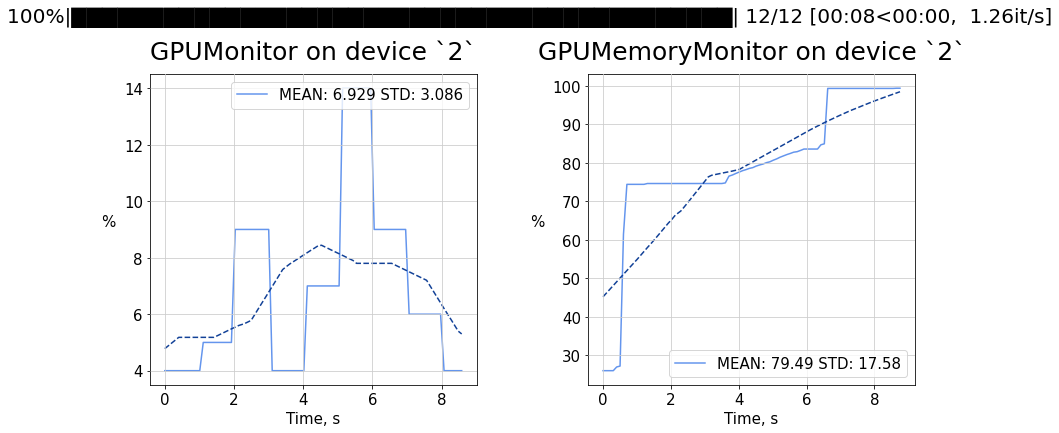

In [9]:
model.eval()

embeddings = []
targets = []

notifier = Notifier('t', graphs=['gpu', 'gpu_memory'])

for batch in notifier(loader):
    inputs = batch['input_tensors'].to(DEVICE)
    batch_embeddings = model(inputs).detach().cpu().numpy()
    embeddings.append(batch_embeddings)
    targets.append(batch['labels'])
    
embeddings = np.vstack(embeddings)
targets = np.hstack(targets)

Before feeding the data into TSNE, let reduce dimensionality via PCA to get rid on noise and fasten up the convergence.

In [10]:
%%time

pca = PCA(n_components=50)
features = pca.fit_transform(embeddings)

CPU times: user 2.18 s, sys: 13.5 s, total: 15.7 s
Wall time: 202 ms


Map embedggins into 2-dimensional space.

In [11]:
%%time

tsne = TSNE(n_components=2, learning_rate=1e-1, init='random', perplexity=30, random_state=SEED)
folded = tsne.fit_transform(features)

CPU times: user 1min 13s, sys: 5.57 s, total: 1min 18s
Wall time: 1.91 s


Visualize resulted projection.

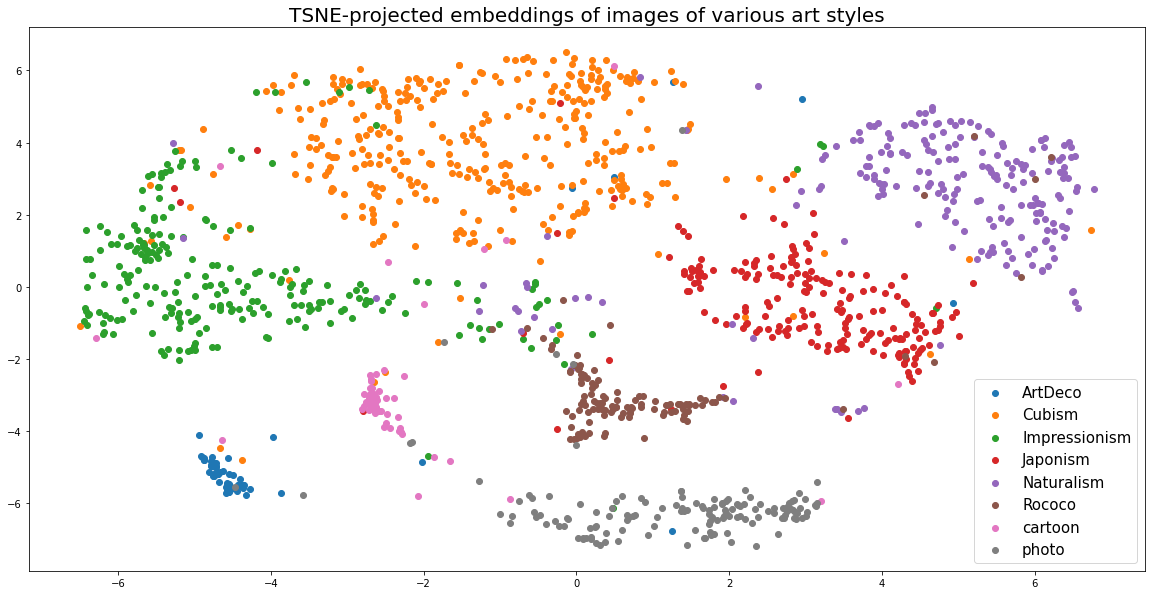

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

for class_index in range(n_classes):
    folded_class = folded[targets == class_index].T
    ax.scatter(*folded_class)

title_label = 'TSNE-projected embeddings of images of various art styles'
title_size = 20
ax.set_title(label=title_label, size=title_size)

legend_size = 15
ax.legend(classes, fontsize=legend_size)

IMAGE_PATH = '../report/tsne.png'
fig.savefig(IMAGE_PATH, facecolor='white', bbox_inches='tight')

As one might notice, being project into a 2d space embeddings of our images fall into rather distinguishable separate clusters.
And though they do overlap each other sometimes, most of the points can be attributed to their cluster of origin rather easily.

What can we say about clusters, looking at the projection map above?

The first obvious renegade is the beloved _ArtDeco_. He seems to be most outlying and different from the others.
However, there are a few samples from _Cubism_, _cartoon_ and _photo_ right near the original ArtDeco group. Since it's rather small, even those few outliers might effect class metrics values rather harsh.

The second interesting fact is that the _photo_ class samples are situated really at the bottom of the projection plot.
And while there are not far from the _Rococo_ labels (which is understandible, since images of both of these classes contain human faces with the highest rate among all other dataset images), _photo_ class samples are have the smallest coordinate by the y-axis, which is probably due to the fact, that photos and paintings are of different nature.

The _cartoon_ cluster stuck in-between _ArtDeco_, _Impressionism_, _Rococo_ and _photos_, while being rather dense, contain a few outsiders near its center, that'll definitely affect class attribution while clustering. Actually, I have an assumption that those two classes, _ArtDeco_ and _cartoon_ are not just underrepresented, but also samples in both groups are very much alike correspondingly. Simply put, images in _ArtDeco_ style in the dataset are looking veeery similar; same goes for _cartoon_. And that is actually not good for their clustering since most probably those styles themselves have much greater diversity in general. And such diverse samples, if being provided to our model in inference, will most probably fall somewhere __not__ in the center of corresponding class cluster, but rather __to the side__. And there are samples from other classes, already waiting, affecting by just their presence nearby, the class attribution process and causing false positive classification errors with respect to the class that's was mistakenly assigned to sample on inference.

The final note will be on so-called "expats" — several samples of well-represented and rather diverse classes, _Japonism_ and _Naturalism_, that've happen to fall rather far from the main congestion of their relatives. Just look, how three red-colored samples from _Japonism_ style are chillin in the top left corner in-between _Impressionism_ and _Cubism_ clusters. And how about _Cubism_ sample right to _Naturalism_ cluster? Something strange is going on there.